In [33]:
import pandas as pd
import numpy as np

from google.colab import drive

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
clinical_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/clinical.csv')

genetic_data = pd.read_csv('/content/drive/My Drive/Projects/multi-view/genetic.csv')

In [36]:
clinical_data.isnull().sum()

,0
participant_id,0
diagnosis,0
roi0,0
roi1,0
roi2,0
...,...
roi140,0
roi141,0
roi142,0
roi143,0


In [37]:
genetic_data.isnull().sum()

,0
participant_id,0
SNP0,0
SNP1,0
SNP2,0
SNP3,0
...,...
SNP95,0
SNP96,0
SNP97,0
SNP98,0


In [38]:
# Merge the datasets on 'participant_id' to ensure both clinical and genetic data have matching participants
merged_data = pd.merge(clinical_data, genetic_data, on='participant_id', how='inner')

# Extract clinical and genetic data matrices
X = merged_data.iloc[:, 2:2 + len(clinical_data.columns) - 1].values
Z = merged_data.iloc[:, 2 + len(clinical_data.columns):].values

In [39]:
X.shape, Z.shape

((1200, 146), (1200, 98))

In [40]:
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

K = 3
lambda_w = 0.1
lambda_s = 0.1
max_iter = 100

V = np.random.rand(X.shape[1], K)  # Clinical data weight matrix
W = np.random.rand(Z.shape[1], K)  # Genetic data weight matrix

U = np.zeros((X.shape[0], K))
for i in range(X.shape[0]):
    U[i, np.random.randint(0, K)] = 1  # Assign each participant to one cluster

# Initialize the residual matrix S (for clustering component)
S = np.zeros_like(X)

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

Z_scaler = StandardScaler()
Z_scaled = Z_scaler.fit_transform(Z)

In [41]:
from scipy.special import logsumexp

def update_U(X, V, W, S, Z_scaled, K):
    N = X.shape[0]
    U = np.zeros((N, K))

    for i in range(N):
        min_loss = float('inf')
        best_k = -1
        for k in range(K):
            clustering_loss = np.linalg.norm(X[i] - V[:, k] - S[i]) ** 2

            z_w = Z_scaled[i] @ W[:, k]
            classification_loss = logsumexp([z_w, 0]) - z_w

            total_loss = clustering_loss + classification_loss

            # Find the cluster with the smallest loss
            if total_loss < min_loss:
                min_loss = total_loss
                best_k = k

        # Assign to the best cluster
        U[i, best_k] = 1

    return U


In [42]:
import numpy as np

def update_V(X, U, S, regularization_strength=1e-6):

    UUT = U.T @ U

    UUT += np.eye(UUT.shape[0]) * regularization_strength

    try:
        V = (X - S).T @ U @ np.linalg.inv(UUT)
    except np.linalg.LinAlgError as e:
        print("Matrix inversion error:", e)

    return V


In [43]:
def update_W(Z, U, W, lambda_w, learning_rate=0.01, max_iter=50):
    N = Z.shape[0]
    K = W.shape[1]

    for _ in range(max_iter):
        gradient = np.zeros_like(W)

        # Compute the gradient for all samples and clusters
        for k in range(K):
            zi = Z
            ui_k = U[:, k]

            sigmoid = 1 / (1 + np.exp(-zi @ W[:, k]))  # Sigmoid for the k-th column of W

            gradient[:, k] = zi.T @ (sigmoid - ui_k) / N  # Average gradient over N samples

        W -= learning_rate * (gradient + lambda_w * np.sign(W))

    return W


In [44]:
def update_S(X, V, U):
    S = X - (V @ U.T).T 
    return S

In [45]:
def compute_loss(X, V, W, U, S, Z_scaled, lambda_w):

    clustering_loss = np.sum(np.linalg.norm(X - (V @ U.T).T - S, axis=1) ** 2)

    sigmoid = 1 / (1 + np.exp(-Z_scaled @ W))  # Sigmoid activation function
    classification_loss = -np.sum(U * np.log(sigmoid))  # Cross-entropy loss

    # Regularization for the weights
    reg_loss = lambda_w * np.sum(np.linalg.norm(W, axis=0) ** 2)

    total_loss = clustering_loss + classification_loss + reg_loss
    return total_loss


Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

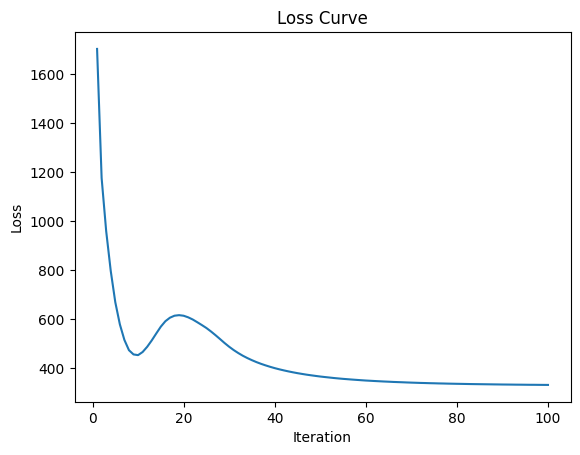

In [46]:
import matplotlib.pyplot as plt

losses = []

for iteration in range(max_iter):
    print(f"Iteration {iteration + 1}/{max_iter}")

    V = update_V(X_scaled, U, S)
    W = update_W(Z_scaled, U, W, lambda_w)
    S = update_S(X_scaled, V, U)
    U = update_U(X_scaled, V, W, S, Z_scaled, K)

    # Compute and store the loss
    loss = compute_loss(X_scaled, V, W, U, S, Z_scaled, lambda_w)
    losses.append(loss)


# Plot the loss curve
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
